# Loading timetable

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from planner import JourneyPlanner
from collections import defaultdict
import pickle
import numpy as np

In [3]:
with open('../data/footpath.pickle', 'rb') as f:
    footpaths = pickle.load(f)

In [4]:
with open('../data/trips.pickle', 'rb') as f:
    trips = pickle.load(f)

In [5]:
with open('../data/stops.pickle', 'rb') as f:
    stops = pickle.load(f)

In [6]:
with open('../data/connections_data.pickle', 'rb') as f:
    connections = pickle.load(f)

In [7]:
with open('../data/confidence.pickle', 'rb') as f:
    confidences = pickle.load(f)

In [8]:
with open('../data/routes.pickle', 'rb') as f:
    routes = pickle.load(f)

In [9]:
np.unique(routes.routes_desc)

array(['Bus', 'Eurocity', 'Eurostar', 'Extrazug', 'ICE', 'InterRegio',
       'Intercity', 'Luftseilbahn', 'RegioExpress', 'S-Bahn', 'Schiff',
       'Standseilbahn', 'TGV', 'Taxi', 'Tram'], dtype=object)

In [10]:
color_dict = {}
route_types = np.unique(routes.routes_desc)
colors = ["red", "yellow",
            "brown",
           "black",
            "cyan",
            "navy",
            "linen",
            "white",
            "tomato",
            "green",
           "purple",
            "olive",
            "lime",
            "orange",
            "greenyellow"]

for x in zip(route_types, colors):
    color_dict[x[0]] = x[1]
    
color_dict["Walking"] = "blue"   

In [11]:
color_dict

{'Bus': 'red',
 'Eurocity': 'yellow',
 'Eurostar': 'brown',
 'Extrazug': 'black',
 'ICE': 'cyan',
 'InterRegio': 'navy',
 'Intercity': 'linen',
 'Luftseilbahn': 'white',
 'RegioExpress': 'tomato',
 'S-Bahn': 'green',
 'Schiff': 'purple',
 'Standseilbahn': 'olive',
 'TGV': 'lime',
 'Taxi': 'orange',
 'Tram': 'greenyellow',
 'Walking': 'blue'}

In [12]:
paper_conn = [[
    ("y", "t", 100000, 110000, "1"),
    ("z", "t", 90000, 120000, "2"),
    ("x", "t", 80000, 130000, "3"),
    ("x", "y", 80000, 90000, "4"),
    ("s", "z", 70000, 80000, "5"),
    ("s", "x", 60000, 70000, "6"),
    ("s", "t", 50000, 140000, "7")
]]
timetable = (None, paper_conn, None, defaultdict(lambda: list()))

In [13]:
timetable = stops, connections, trips, footpaths, confidences

# Planning a route and defining function to plot

In [14]:
planner = JourneyPlanner(timetable)

journeys = planner.plan_route(4, "8503000:0:9", "8590632", 1653453975, 1653471975, minimum_confidence = 0, max_changes = 3, verbose=True)

#the following makes the connection index go out of range
# journeys = planner.plan_route(2, "8502555", "8502495", 1653491740, 1653501740, max_changes = 10)

#the following makes the kernel die
#s = planner.plan_route(3, "8503000", "8590318", 1653491740, 1653501740, 10)
print(len(journeys))

Starting execution of CSA...
Starting extraction of paths... found 8 paths.
Starting processing of paths... processed 8 journeys.
Starting sorting of paths...
End of computation.
8


In [15]:
j = journeys[0]

In [16]:
from planner import JourneyPlanner
from collections import defaultdict
import pickle
import ipywidgets as widgets
from IPython.display import display, clear_output
import datetime
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import plotly
import matplotlib.pyplot as plt
import pickle
from journey import *

1653471120
177
1653471960
386


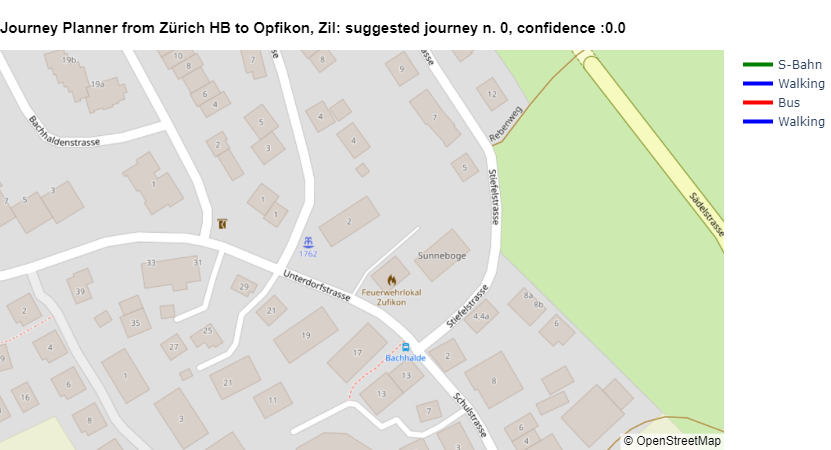

In [55]:
def visualize_map_scattermapbox(journey, plot_number = 0):
    
    
    
    # l is the layout of the plot, we use to set the title, the margins and the style of the map
    departure_station = journey.links[0].dep_stop['stop_name']
    arrival_station = journey.links[-1].arr_stop['stop_name']
    confidence = journey.confidence
    l = go.Layout(
#         title= f'Journey Planner from {departure_station} to {arrival_station}: suggested trip n. {plot_number}, confidence :{confidence}', 
        
        title=dict(
        text=f'<b>Journey Planner from {departure_station} to {arrival_station}: suggested journey n. {plot_number}, confidence :{confidence}</b>',
        x=0,
        y=0.95,
        font=dict(
            family="Arial",
            size=15,
            color='#000000'
        )),
        margin ={'l':0,'t':50,'b':0,'r':0},
        mapbox = {
            'center': {'lon': 10, 'lat': 10},
            'style': "open-street-map",
            'center': {'lon':8.57 , 'lat': 47.40},
            'zoom': 9.8,}
#         title_x = 0.41
    )
    
    # we initialize the map with the layout we created above
    
    fig = go.Figure(go.Scattermapbox(
            mode = "markers+lines",
            marker = {'size': 10},
            ), l)
    
    # here we iterate through the path in order to plot each part of the trip
    i = 0
    for x in journey.links:
        
        if isinstance(x, Change):  # skipping changes, Changes should not be plotted
            continue
            
        #we should not plot walks where you stay inside the same station
        if isinstance(x, Footpath):
            if x.dep_stop['parent_station'] == x.arr_stop['parent_station'] and x.dep_stop['parent_station'] != '': 
                continue
            transport_type = "Walking" # this is used later for plotting the legend
            print(x.dep_time)
            print(x.duration)
            
        #getting the transport type of the trip, used for plotting the legend
        if isinstance(x, Trip):
            transport_type = routes.drop_duplicates("route_id").set_index("route_id").loc[x.trip['route_id']]["routes_desc"] 
            

        
        arr_df = pd.DataFrame(x.arr_stop, index = ["arr"])
        dep_df = pd.DataFrame(x.dep_stop, index = ["dep"])
        #to plot the lines we merge the arrival and departure stop in one df
        arr_dep_df = pd.concat([arr_df, dep_df])

        
        fig.add_trace(go.Scattermapbox(mode = "lines",
                                        lon = arr_dep_df.stop_lon,
                                        lat = arr_dep_df.stop_lat,
                                        marker = {'color': color_dict[transport_type]},
                                        line={'width':4},
                                        name = f"{transport_type}"))

        fig.add_trace(go.Scattermapbox(mode = "markers",
                                        lon = [x.dep_stop['stop_lon']],
                                        lat = [x.dep_stop['stop_lat']],
                                        showlegend=False,
                                        marker = {'size': 12,'color': color_dict[transport_type]},
                                        hovertext = x.dep_stop['stop_name']))
        
        
        i += 1
        
    fig.add_trace(go.Scattermapbox(mode = "markers",
                                        lon = [x.arr_stop['stop_lon']],
                                        lat = [x.arr_stop['stop_lat']],
                                        showlegend=False,
                                        marker = {'size': 12,'color': color_dict[transport_type]},
                                        hovertext = x.arr_stop['stop_name']))

#     plotly.offline.plot(fig)               #uncomment this if you want the map to open also in a new tab of the browser
    fig.show()

   

visualize_map_scattermapbox(j)

# Setting up the widgets and plotting

In [18]:
import ipywidgets as widgets
from IPython.display import display, clear_output

In [19]:
stop_names = []
for key in stops.keys():
    stop_names.append(stops[key]["stop_name"])

stop_names = np.unique(sorted(stop_names))        #getting all the stationnames and sorting them in alphabetical order

In [20]:
# Below we define all the widgets
import datetime
confidence_level =widgets.FloatSlider(
    description = "Confidence Interval",
    value=0,
    min=0,
    max=1.0,
    step=0.01,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    style= {'description_width': 'initial'}
)

datetime_picker = widgets.DatePicker(
    value = datetime.datetime.now().date(),
    description='Date of the trip',
    disabled=False,
    style= {'description_width': 'initial'}
)

aux = datetime.datetime.now()
max_arrival_time_hour = widgets.Dropdown(
    value = datetime.datetime.now().time().hour + 3,
    options= [i for i in range(1,25)],
    description='Max Arrival Hour:',
    disabled=False,
    style= {'description_width': 'initial'}
)

max_arrival_time_minute = widgets.Dropdown(
    value = datetime.datetime.now().time().minute,
    options= [i for i in range(1,60)],
    description='Max Arrival Minute:',
    disabled=False,
    style= {'description_width': 'initial'}
)


min_departure_time_hour = widgets.Dropdown(
    value = datetime.datetime.now().time().hour,
    options= [i for i in range(1,25)],
    description='Min Departure Hour:',
    disabled=False,
    style= {'description_width': 'initial'}
)


min_departure_time_minute = widgets.Dropdown(
    value = datetime.datetime.now().time().minute,
    options= [i for i in range(1,60)],
    description='Min Departure Hour:',
    disabled=False,
    style= {'description_width': 'initial'}
)



departure_station = widgets.Dropdown(
    options= stop_names,
    description='Departure Station:',
    disabled=False,
    style= {'description_width': 'initial'}
)

arrival_station = widgets.Dropdown(
    options= stop_names,
    description='Arrival Station:',
    disabled=False,
    style= {'description_width': 'initial'}
)


max_changes = widgets.IntText(
    value=10,
    description='Max. number of changes:',
    disabled=False,
)



show_k_journeys = widgets.Dropdown(
    value = 5,
    options= [i for i in range(1,11)],
    description='Max n. of journeys to display:',
    disabled=False,
    style= {'description_width': 'initial'}
)

layout = widgets.Layout(width='auto', height='40px')

button = widgets.Button(
    description='Find the best route!',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check', # (FontAwesome names without the `fa-` prefix)
    layout = layout
)


out = widgets.Output()

# The following functions defines what happens when we press the button

                             
def button_action(button):
    
    out.clear_output()   # each time we press the button we clear the previous output
    
    with out:

        dep_station_name = departure_station.value
        arr_station_name = arrival_station.value
        dep_station_ids = [k for k,v in stops.items() if v['stop_name'] == dep_station_name] #exctracting all ids related to the departure station name. Later, we use only the first one (i.e. as input of the planner we only give dep_station_ids[0])
        arr_station_ids = [k for k,v in stops.items() if v['stop_name'] == arr_station_name] #exctracting all ids related to arrival station name. Later, we use only the first one (i.e. as input of the planner we only give arr_station_ids[0])

            
        weekday = datetime_picker.value.weekday()
        if not(weekday in [0,1,2,3,4]):
            raise Exception("You cannot choose Saturday or Sunday")

        max_time = datetime.time(max_arrival_time_hour.value, max_arrival_time_minute.value)
        min_time = datetime.time(min_departure_time_hour.value, min_departure_time_minute.value)
        date_value_from_connections = datetime.datetime.fromtimestamp(connections[0][2]) #extracting the date timestamp from connections, since the algo needs this day in order to run

        timestamp1 = int(datetime.datetime.combine(date_value_from_connections, min_time).timestamp()) #combining the date from connections with the min time provided by the user
        timestamp2 = int(datetime.datetime.combine(date_value_from_connections, max_time).timestamp()) #combining the date from connections with the max time provided by the user
        inputs = [weekday, dep_station_ids[0], arr_station_ids[0], timestamp1, timestamp2, max_changes.value, confidence_level.value]

        planner = JourneyPlanner(timetable)
        print("Loading...")
        journeys = planner.plan_route(weekday, dep_station_ids[0], arr_station_ids[0], timestamp1, timestamp2, confidence_level.value, max_changes.value)
        

        print("Done. Total Number of journeys found", len(journeys))
        max_journeys = show_k_journeys.value #used to visualize only first k journeys
            
        for i in range(len(journeys[:max_journeys])): # we plot only first k journeys
            visualize_map_scattermapbox(journeys[i], i+1) 
        
button.on_click(button_action)

/opt/conda/lib/python3.9/site-packages/traitlets/traitlets.py:588: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [21]:
import datetime
display(datetime_picker, min_departure_time_hour,min_departure_time_minute, max_arrival_time_hour, max_arrival_time_minute , departure_station, arrival_station, confidence_level, max_changes, show_k_journeys, button, out)

DatePicker(value=datetime.date(2022, 5, 28), description='Date of the trip', style=DescriptionStyle(descriptio…

Dropdown(description='Min Departure Hour:', index=9, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

Dropdown(description='Min Departure Hour:', index=31, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

Dropdown(description='Max Arrival Hour:', index=12, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15…

Dropdown(description='Max Arrival Minute:', index=31, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

Dropdown(description='Departure Station:', options=('Aathal', 'Adlikon b. R., Dorf', 'Adlikon b. R., Leematten…

Dropdown(description='Arrival Station:', options=('Aathal', 'Adlikon b. R., Dorf', 'Adlikon b. R., Leematten',…

FloatSlider(value=0.0, continuous_update=False, description='Confidence Interval', max=1.0, step=0.01, style=S…

IntText(value=10, description='Max. number of changes:')

Dropdown(description='Max n. of journeys to display:', index=4, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), style…

Button(description='Find the best route!', icon='check', layout=Layout(height='40px', width='auto'), style=But…

Output()